# Social Computing/Social Gaming - Summer 2021
# Exercise Sheet 5 - Hate Speech
Online hate speech is a large scale phenomenon that gained more and more traction in modern society in recent years. Violence attributed to online hate speech has increased worldwide. The same technology that allows social media to galvanize activist movements and NGOs can be used by hate/crime groups seeking to organize and recruit. It also allows conspiration theorists to reach audiences far broader than their core community. It is time – now more than ever –  to put systems in place that make sure social media is not used as a tool to conduct criminal activities. Fortunately, modern technology allows us to do just that.

In this exercise sheet, we will attempt to accurately and automatically detect two instances of hate speech in Twitter: sexism and racism. The first step in this process will be to prepare the data before it is fed to the model. We do this with the help of the Universal Sentence Encoder, which is explained in more detail later. Additionally, we also need to encode the labels and split the data.

We then take two different approaches in classifying the data. In other words, we will create, train, evaluate and compare two models. One of them is purely based on text (the Base Model) and the other also takes the social context of the users into account (the Social Model).

## Why Twitter?
Hate crimes are communicative acts, often provoked by events that incite retribution in a targeted group. The continued growth of online social networks and micro-blogging Web services, such as Twitter, enable an extensive and near real-time data source through which the analysis of hateful and antagonistic responses to “trigger” events can be undertaken. Such data affords researchers with the possibility to measure the online social mood and emotion following large-scale, disruptive, and emotive events. Twitter is a defensible and logical source of data for such analysis given that users of social media are more likely to express emotional content due to deindividuation (anonymity, lack of self-awareness in groups, disinhibition) [1].

## Task 5.0: The Data
For this, we have picked the dataset of Waseem and Hovy [2], in a slightly modified version. The collection originally contained 16,914 labeled tweets, however some of them are not accessible via Twitter API anymore. As a consequence, the dataset now contains 16,849 tweets divided in the following categories: 3,378 *sexism*, 1,970 *racism* and 11,501 *neither*.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Reads the data set from a .csv file
waseem_hovy = pd.read_csv('tweets.csv')

waseem_hovy = waseem_hovy.astype(str)

# This drop operation is necessary because of an inconsistency in the dataset
waseem_hovy = waseem_hovy.drop([3343, 3344])
waseem_hovy = waseem_hovy[['text', 'label']]

# We need to do a unique and precise reordering to match with graph information later on
unique_tweets, indices = np.unique(waseem_hovy['text'].to_numpy(), return_index=True)
ordered_labels = waseem_hovy['label'].to_numpy()[indices]
waseem_hovy = pd.DataFrame(np.stack((unique_tweets, ordered_labels), axis=1), columns=['text', 'label'])

C:\ProgramData\Anaconda3\envs\socialComputing\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# See the summary of the dataset's content

print("TOTAL TWEETS: {}, RACIST: {}, SEXIST: {}, NEITHER: {}".\
      format(len(waseem_hovy), len(waseem_hovy[waseem_hovy["label"] == 'racism']), len(waseem_hovy[waseem_hovy["label"] == 'sexism']), len(waseem_hovy[waseem_hovy['label'] == 'none'])))

TOTAL TWEETS: 16849, RACIST: 1970, SEXIST: 3378, NEITHER: 11501


## Task 5.1: Preprocessing 

### a) Encode the labels
In order for [Keras](https://keras.io/about/) [3] to work with the labels, they need to have a specific format. For every tweet, we need a 3-dimensional vector where the assigned category is marked by `1` for that index and the rest of the vector is marked with `0`. This kind of representation is called One Hot Encoding.  

Map the labels from the `label_mapping = ['sexism' 'none' 'racism']` to a 3-dimensional vector.

**Example**: If a tweet is racist, the vector will look like this: `[0, 0, 1]`.

In [4]:
from sklearn.preprocessing import LabelBinarizer

In [5]:
# Extract labels from dataset

labels = np.array(waseem_hovy["label"].tolist())

print(labels[0])
mapping_dict ={'sexism':[1,0,0],'none':[0,1,0],'racism':[0,0,1]}
waseem_hovy['label_mapping'] = waseem_hovy["label"].map(mapping_dict)
print(waseem_hovy['label_mapping'])
label_mapping = [ mapping_dict[elem] for elem in labels]
# TODO: Encode labels as binary One Hot vectors
# Hint: First map the labels to integer than binarize them


# Shows the actual shape of the labels
print(labels.shape)
print(label_mapping)

sexism
0        [1, 0, 0]
1        [0, 1, 0]
2        [0, 1, 0]
3        [0, 1, 0]
4        [1, 0, 0]
           ...    
16844    [0, 1, 0]
16845    [0, 1, 0]
16846    [0, 1, 0]
16847    [0, 1, 0]
16848    [0, 1, 0]
Name: label_mapping, Length: 16849, dtype: object
(16849,)
[[1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [1, 0, 0], [0, 1, 0], [1, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 0, 1], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0]

### b) Universal Sentence Encoder
Google's Universal Sentence Encoder ([USE](https://tfhub.dev/google/universal-sentence-encoder/4) [4]) is a convenient way to map any type of sentence to a 512-dimensional vector. In these 512-dimensional vectors semantic meaning is encoded.

In [6]:
import tensorflow_hub as hub


# Run this code block only once as the download will take some time and embedding is very memory expensive!
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In this task you are suppossed to get a feeling for this type of embedding. Find a pair of sentences that are similar in their meaning but not syntactically. After that, think of two semantically very different sentences. 
Obtain the values for them and compare them.

**TODO: Write your observations here**

Comparing 512 values is a bit cumbersome..., having a look at the samples one can see that an equal sentence has the same values and a more equal sentence seem to have more similiar values.

Therefore, I calculated the Euclidean Distance to compare the embedings of the sentences. Showing that it works (baseline has no distance, similar less than not_similiar)

Important for working with the embedding is, that each sentence seems to have a unique embedding and is not depending on other sentences wich where requested with the same call.

In [7]:
import tensorflow as tf
# Try out USE here
baseline= embed([
    "What is your age?",
    "What is your age?",])

print(baseline)
print("Euclidean Distance for baseline: ",tf.norm(baseline[0]- baseline[1], ord='euclidean'))

similiar = embed([
    "What is your age?",
    "How old are you?",])

print(similiar)
print("Euclidean Distance for similiar: ",tf.norm(similiar[0]- similiar[1], ord='euclidean'))

not_similiar = embed([
    "I am hungry!",
    "What time is it now?",])

print(not_similiar)
print("Euclidean Distance for not_similiar: ",tf.norm(not_similiar[0]- not_similiar[1], ord='euclidean'))


tf.Tensor(
[[-0.08415682 -0.08687919  0.03446117 ... -0.01439386 -0.04546222
   0.03639967]
 [-0.08415682 -0.08687919  0.03446117 ... -0.01439386 -0.04546222
   0.03639967]], shape=(2, 512), dtype=float32)
Euclidean Distance for baseline:  tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(
[[-0.08415682 -0.08687919  0.03446117 ... -0.01439386 -0.04546222
   0.03639967]
 [-0.06045128 -0.00204544  0.02656927 ...  0.00764413 -0.02669661
   0.05110301]], shape=(2, 512), dtype=float32)
Euclidean Distance for similiar:  tf.Tensor(0.6299415, shape=(), dtype=float32)
tf.Tensor(
[[ 0.03698174 -0.02678561  0.0697929  ... -0.00992562  0.06266066
  -0.0909206 ]
 [-0.01967761 -0.07189929  0.00473396 ... -0.0119966   0.04123623
   0.01193676]], shape=(2, 512), dtype=float32)
Euclidean Distance for not_similiar:  tf.Tensor(1.2121924, shape=(), dtype=float32)


In [8]:
# TODO: Now encode our dataset's tweets
# TODO: Now encode our dataset's tweets
def list_helper(input):
    return [input]

waseem_hovy.info()
waseem_hovy['embedding']=waseem_hovy['text'].apply(list_helper).apply(embed)
print(waseem_hovy['embedding'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16849 entries, 0 to 16848
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           16849 non-null  object
 1   label          16849 non-null  object
 2   label_mapping  16849 non-null  object
dtypes: object(3)
memory usage: 395.0+ KB
0        ((tf.Tensor(0.015782943, shape=(), dtype=float...
1        ((tf.Tensor(0.019881986, shape=(), dtype=float...
2        ((tf.Tensor(-0.016077917, shape=(), dtype=floa...
3        ((tf.Tensor(0.04290085, shape=(), dtype=float3...
4        ((tf.Tensor(0.0055910265, shape=(), dtype=floa...
                               ...                        
16844    ((tf.Tensor(0.06901474, shape=(), dtype=float3...
16845    ((tf.Tensor(-0.016063154, shape=(), dtype=floa...
16846    ((tf.Tensor(0.06784237, shape=(), dtype=float3...
16847    ((tf.Tensor(-0.011505629, shape=(), dtype=floa...
16848    ((tf.Tensor(0.031104399, shape=(), d

## Task 5.2: Base Model

### a) Base Model creation
In this code we create our base model and train it afterwards using the Keras library. We use a simple Neural Network to build this model. You can read about Neural Networks here in case you are not familiar with them.
You can get a basic intuition for Neural Networks [here](https://medium.com/@shaistha24/basic-concepts-you-should-know-before-starting-with-the-neural-networks-nn-3-6db79028e56d) [5]. 

For the base model we have our 512 dimensional input layer. Then we have a fully connected layer with 100 nodes and with a dropout rate of 0.5 is added. For now, you do not need to know what dropout is. After the dropout, another fully connected layer with 50 nodes is added and we once again add a 0.5 dropout rate.
Our output layer has 3 nodes: One for "sexism", "none" and "racism". The computed values for these last 3 nodes correspond to the probability of belonging to either one of our categories.

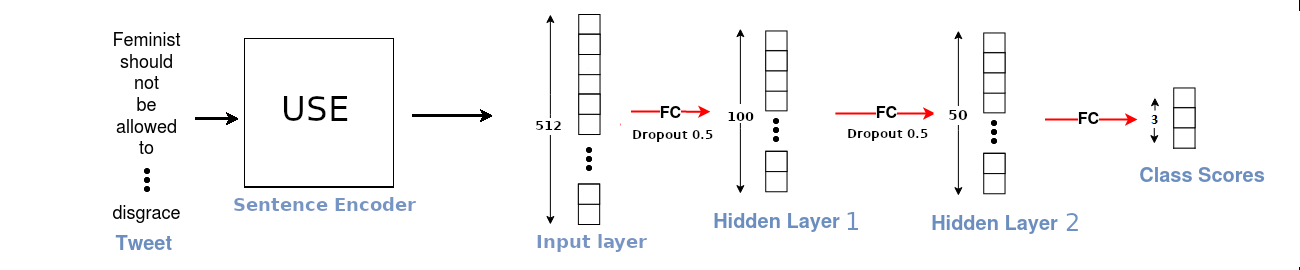

![title](img/base_model.png)

In [48]:
from keras import layers
from keras.models import Model
from keras import backend as K
import tensorflow as tf
import tensorflow.keras.callbacks as callbacks


In [31]:
BATCH_SIZE = 32

In [49]:
ENCODING_DIM = 512

text = layers.Input(shape=(ENCODING_DIM, ))

x1 = layers.Dense(100, activation='relu')(text)
x1 = layers.Dropout(0.5)(x1)

# TODO: The 50 nodes layer with 0.5 dropout is missing. Add this layer between the 100 layer and the output layer
x2 = layers.Dense(50, activation='relu')(x1)
x2 = layers.Dropout(0.5)(x2)

output = layers.Dense(3, activation="softmax") (x2)

base_model = Model(inputs=[text], outputs=output)

In [50]:
# Compiles the model defining loss, accuracy metric and optimizer

# Check the internet to unterstand what impact the learning rate (lr) has!
optimizer = tf.keras.optimizers.Adam(lr=0.0005)

base_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['categorical_accuracy'])
base_model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               51300     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 153       
Total params: 56,503
Trainable params: 56,503
Non-trainable params: 0
__________________________________________________

### b) Train-Test split for Base Model
Splitting our labeled data into a train test and validation set is a common practice. 
* Train set: This set is used to train our model on. The model will try to learn from it.
* Validation set: This set is used to choose hyper-parameters. Since creating good models requires to find the right parameters (e.g. what kind of activation function, how many epochs etc.) this set is used to maximize the performance of a model for a fixed choice of parameters.
* Test set: This set is used to evaluate our final model on. After the model has been trained and a final decision for hyper parameters has been made, the model will be evaluated on this set only. No more parameters should be changed after that.

This approach helps to identify models that actually generalize well and not just perform well because we adapted the parameters to maximize the performance on one particular set.

We will use 60% of our dataset to train our model (the train set) and the remaining 20% to evaluate our model (the test set).

**Hint:** The sklearn library offers a function that could help you out with this task.

In [51]:
from sklearn.model_selection import train_test_split

# TODO: Split tweets and labels in Train/Test/Validation 60/20/20
train, test_val=train_test_split(waseem_hovy, test_size=0.4, random_state=42)

val,test = train_test_split(test_val,test_size=0.5,random_state=42)

X_train = np.vstack(train["embedding"])
y_train = np.vstack(train['label_mapping'].apply(np.squeeze))
X_val = np.vstack(val["embedding"])
y_val = np.vstack(val['label_mapping'].apply(np.squeeze))

X_test = np.vstack(test['embedding'])
y_test = np.vstack(test['label_mapping'].apply(np.squeeze))


print("Training data shape: {}, Labels shape: {}".format(X_train.shape, y_train.shape))
print("Test data shape: {}, Labels shape: {}".format(X_test.shape, y_test.shape))
print("Validation data shape: {}, Labels shape: {}".format(X_val.shape, y_val.shape))

Training data shape: (10109, 512), Labels shape: (10109, 3)
Test data shape: (3370, 512), Labels shape: (3370, 3)
Validation data shape: (3370, 512), Labels shape: (3370, 3)


### c) Train the Base Model

**1.** Train the model. You can do so by using the `fit()` function from the Keras library. Call the function with `epochs=20`. Assign the return value from the `fit()` function to the `model_training` variable. It is then used to plot the model's accuracy on the train and validation set at each epoch.

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20

Epoch 00016: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
{'loss': [0.6995830535888672, 0.4954366981983185, 0.4596060514450073, 0.445770800113678, 0.42676931619644165, 0.41841888427734375, 0.40703660249710083, 0.3985934257507324, 0.3881211280822754, 0.38045915961265564, 0.3707147538661957, 0.35979384183883667, 0.3531370162963867, 0.34754839539527893, 0.33447548747062683, 0.3252740800380707, 0.3114933371543884, 0.3066972494125366, 0.30451294779777527, 0.30653515458106995], 'categorical_accuracy': [0.7155999541282654, 0.7970125675201416, 0.8112573027610779, 0.815609872341156, 0.823226809501648, 0.8283707499504089, 0.8339104056358337, 0.8342071175575256, 0.8407359719276428, 0.8438025712966919, 0.8469680547714233, 0.8520130515098572, 0.857

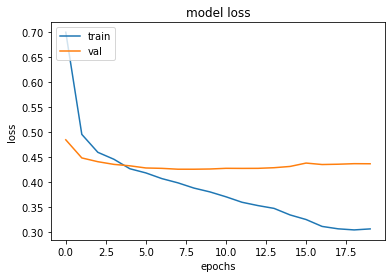

In [52]:
from matplotlib import pyplot as plt

BATCH_SIZE = 32
checkpoint = callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_learning_rate = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=0, mode='min')
# TODO: Train the model
# Hint: When using the fit function, also pass the validation_data as a parameter
model_training=base_model.fit(
    x=np.asarray(X_train).astype('float32'),
    y=np.asarray(y_train).astype('float32'),
    batch_size=BATCH_SIZE,
    epochs=20,
    verbose="auto",
    callbacks=[checkpoint,reduce_learning_rate],
    validation_split=0.0,
    validation_data=(X_val,y_val),
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=20,
    use_multiprocessing=True,
)


# Print the model's history and plot the loss for each epoch
print(model_training.history)
plt.plot(model_training.history['loss'])
plt.plot(model_training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**2.** After you have looked at the graph, what do you think is an appropriate amount of `epochs`? Briefly explain at which amount of epochs the model seems to be underfitting or overfitting and how this depends on the learning rate?

**TODO: Write your observations here**

As 20 epochs did not show overfitting I increased the learning rate by a factor of 10.
Overfitting happens when the network only specializes on the training data but is not any more capable of improving on the validation data as well.

With the changed learning rate we observe overfitting after ~epoch 2 when the training /validation curves intersect.
As I trained with the previous learning rate and ~40 epochs and received a similiar best validation loss, I think that the new learning rate is better.

Interestingly, while overfitting starts at epoch 3 the validation loss still improves a little bit till epoch 7 where it has its best result.

We select the best result using a ModelCheckpoint callback

### d) Evaluate the Base Model

The F1 score is a universal measurement of a test's accuracy. It is calculated as the harmonic mean of *precision* and *recall*. 

- **precision** refers to the number of true positives divided by the number of all positives
- **recall** refers to the number of true positives divided by the number of relevant elements  


$$F_{1} = \frac{2}{recall^{-1} + precision^{-1}} = \frac{tp}{tp+\frac{1}{2}(fp+fn)}$$  

where
*   tp = true positives
*   fp = false positives
*   fn = false negatives  

**1.** Why would we prefer the F1 Score over only the precision?

**2.** Evaluate the text model with an F1 score.

**TODO 1: Write your explanation here**
F1-score is favourable as it gives weight to wether  a sentence label was correctly predicted (precision) but does also punish if a sentence_labgel was predicted wrongly.



In [15]:
from src.evaluation import f1_score_overall
from src.evaluation import take_decisions
from sklearn.metrics import f1_score

In [53]:
# TODO 2: Evaluate text model
# Hint: You can lookup the evaluation.py in the src folder for documentation
# the f1_score_overall is a quite ill explained/documented helper function ( in particular as you dont tell us what variables should have what format),
# understanding and adjusting my code takes longer than doing it myself...

#predict
predictions=base_model.predict(X_test)

#transform prediction to 0 & 1
transformed_predictions = np.zeros_like(predictions)
transformed_predictions[np.arange(len(predictions)), predictions.argmax(1)] = 1
transformed_predictions=transformed_predictions.astype(int)

#calculate f1
overall = 0
for i in range(0,3):
    current = f1_score(y_test.T[i], transformed_predictions.T[i])
    print ( "F1-score for class ",i," is: ", current)
    overall+=current

print("F1-score overall is: ",overall/3)

F1-score for class  0  is:  0.67003367003367
F1-score for class  1  is:  0.8753416018499055
F1-score for class  2  is:  0.7396226415094339
F1-score overall is:  0.7616659711310031


## Task 5.3: Preprocessing for Social Model
Now that we have evaluated our base model we can try to enhance it by using some sort of a social context. To do so, we are using our base model's prediction to compute an average hate score for each of the followers of an author. This means that for each author we take all his follower's tweets and predict the label. We then take the average of each prediction which results in our average hate score.

For each tweet we then not only feed in the tweet itself, but also the hate score.

### Load adjacency matrix for users

In order to create our social model, we first need to load the adjacency matrix. This matrix represents the follower network between all users that have written the 16849 tweets (crawled by Linda Jahn [6]). You can check the `extend_data.ipynb` file to find out how the adjacency matrix was created.

The 16849 tweets were written by 2031 distinct users. This results in a 2031x2031 matrix.

In [17]:
# Load users adjacency matrix
users_adjacency_matrix = np.load("pickle_files/users_data/users_adjacency_matrix.npy")

### a) Graph visualization & manipulation
Now we are going to plot the previously loaded adjacency matrix. Since we are going to feed the matrix to the Neural Network later, and because the user network is just a tiny subset of the whole Twitter network it is important to check if the network contains any useful information.


**1.** Plot the graph corresponding to the given adjacency matrix.  
**Note:** For better visualization, the nodes are color-coded based on their degree.

In [18]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt


Total number of nodes: 2031


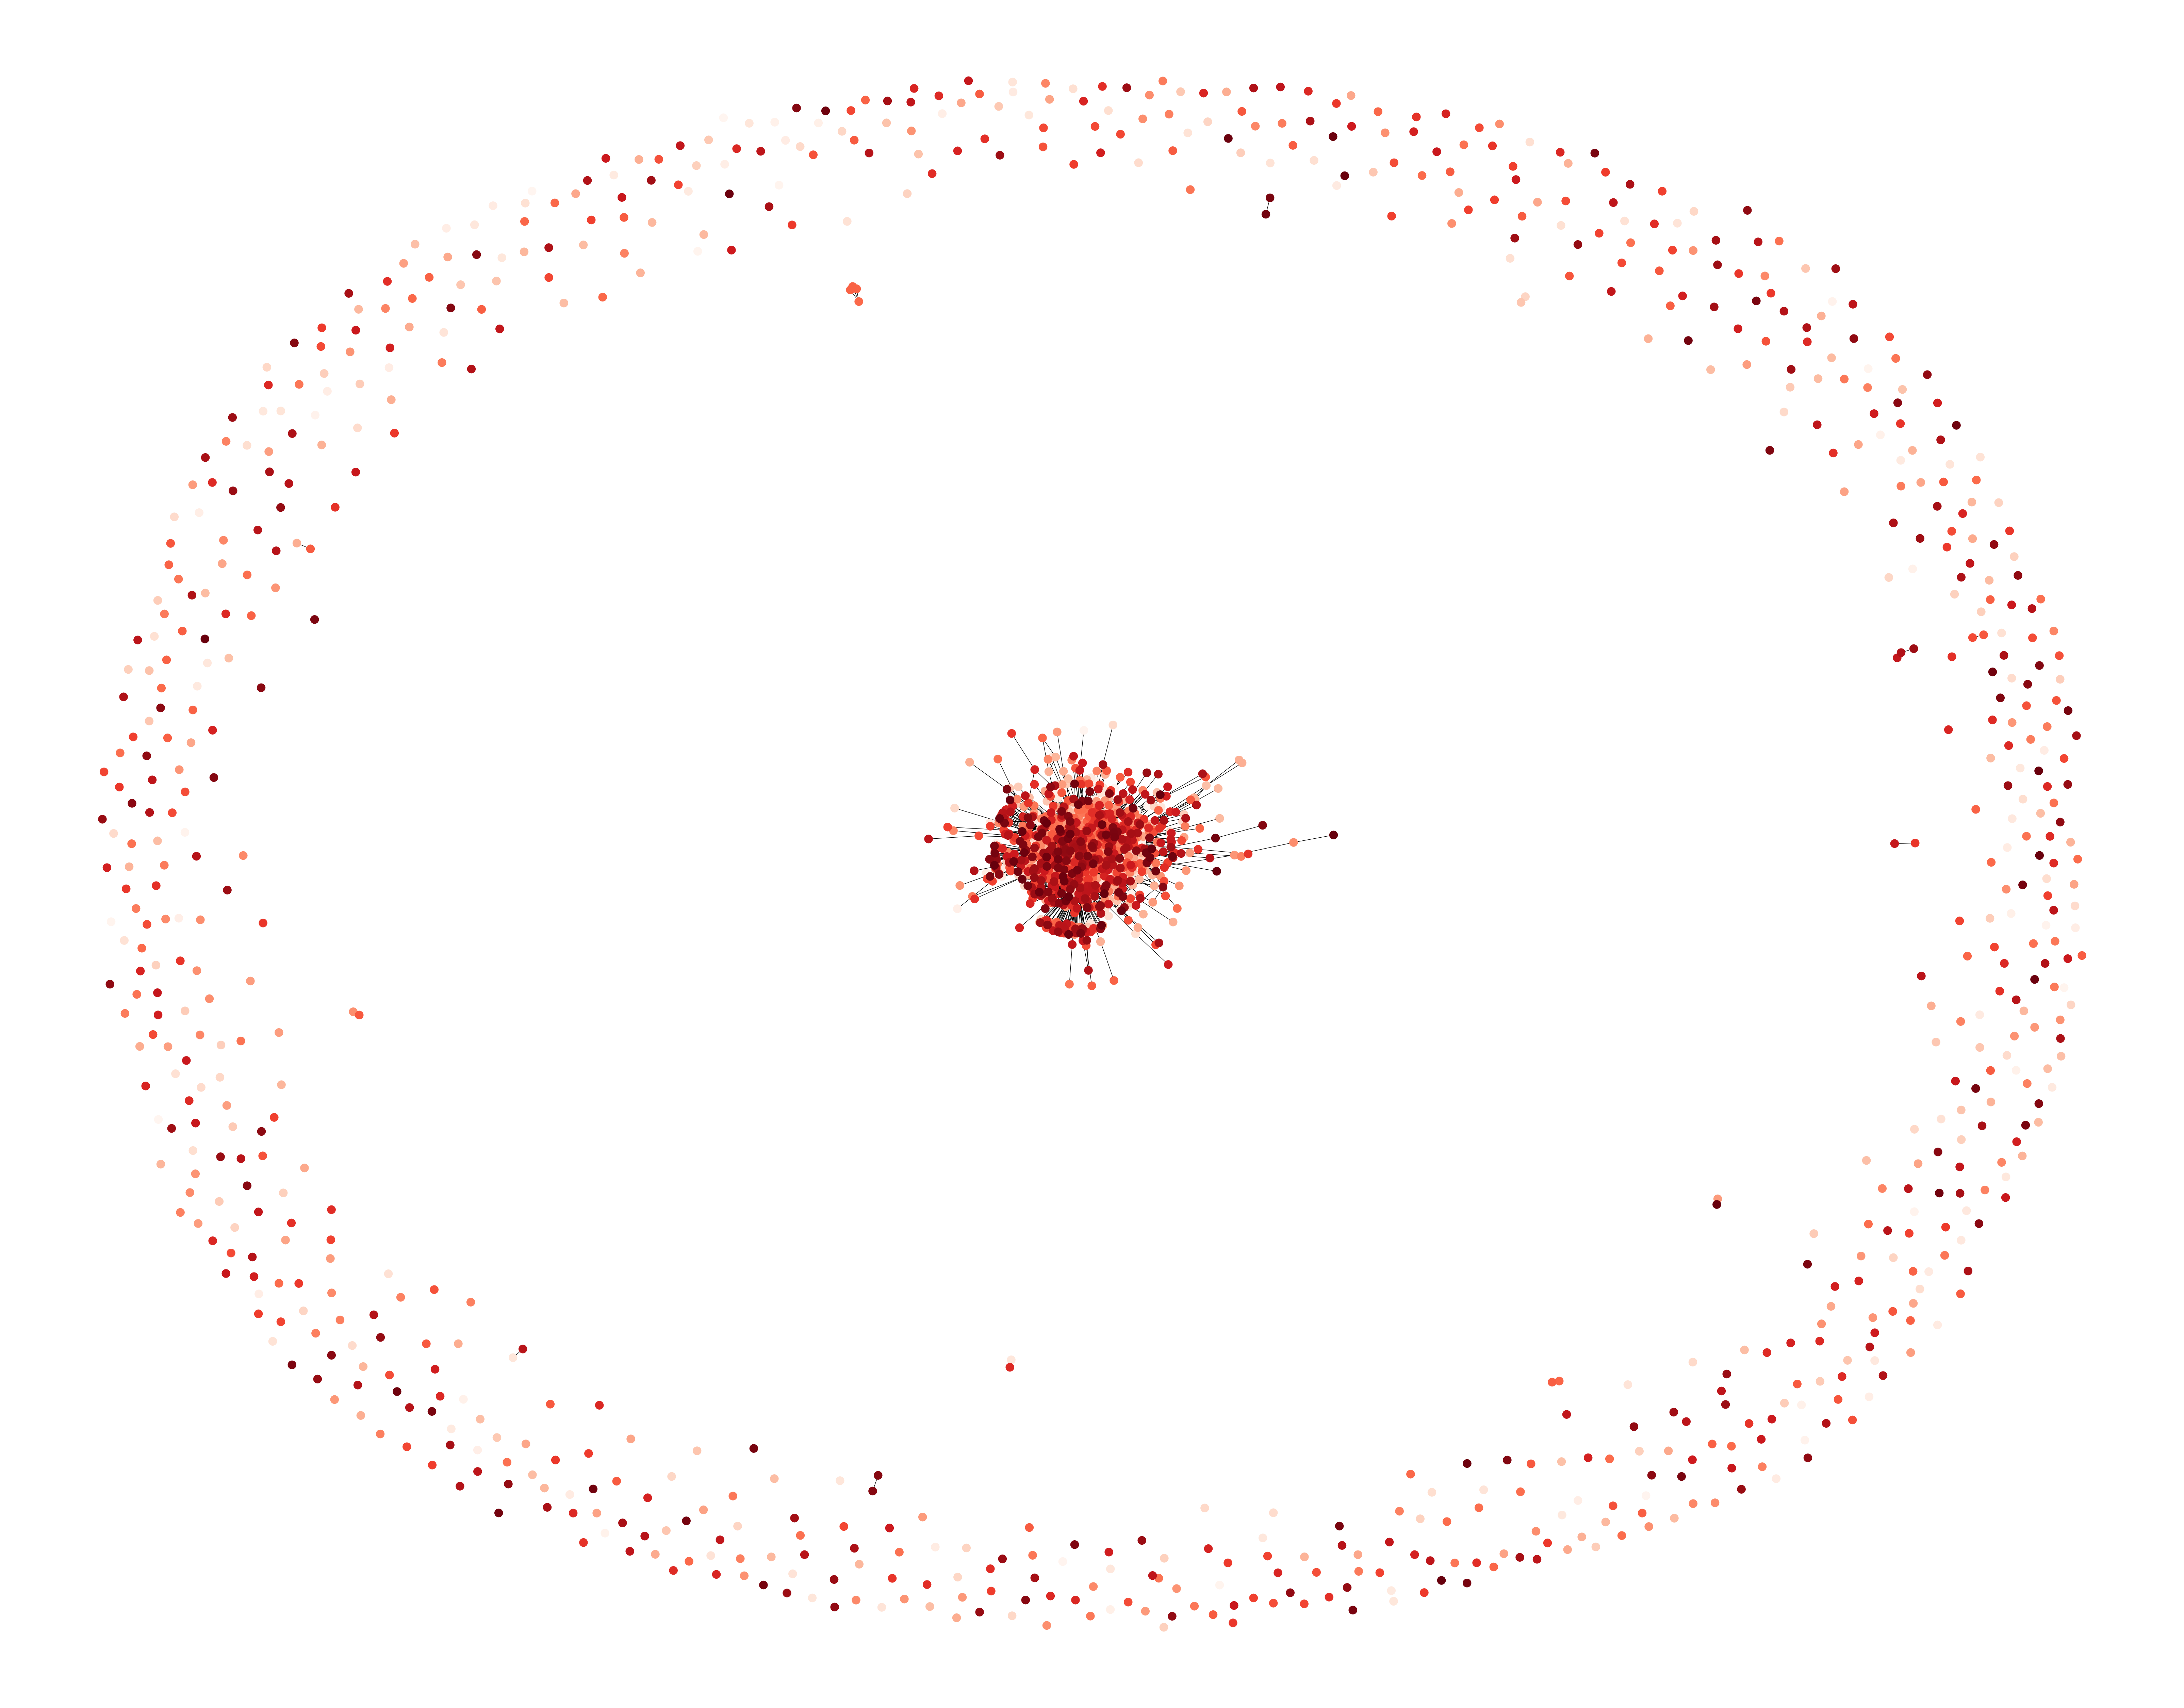

In [19]:
print(nx.from_numpy_matrix(users_adjacency_matrix))
def show_graph(users_adjacency_matrix):

    # TODO 1:
    graph =nx.from_numpy_matrix(users_adjacency_matrix)

    
    print("Total number of nodes:", nx.number_of_nodes(graph))
    
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(64, 50), dpi=100)
    nx.draw(graph,
            node_size=300,
            node_color=range(nx.number_of_nodes(graph)),
            cmap=plt.cm.Reds,
            pos=nx.spring_layout(graph)
           )
    plt.show()

    
show_graph(users_adjacency_matrix)

**2.** Briefly describe the graph. How many communities do you think it depicts? 

**TODO 2: Write your observations here**

One can see one big circle with independent nodes or very small groups, and one big community in the middle.

**3.** Now let us try to actually calculate the number of communities within this graph. First, get rid of the uninteresting nodes that have zero or very few edges and just inspect the "core" graph. Expand on the code that you have written in the exercise above.  
**Hint**: You can do this by excluding all nodes with an `nx.eigenvector_centrality()` lower than $10^{-8}$.

Total number of significant nodes: 1176


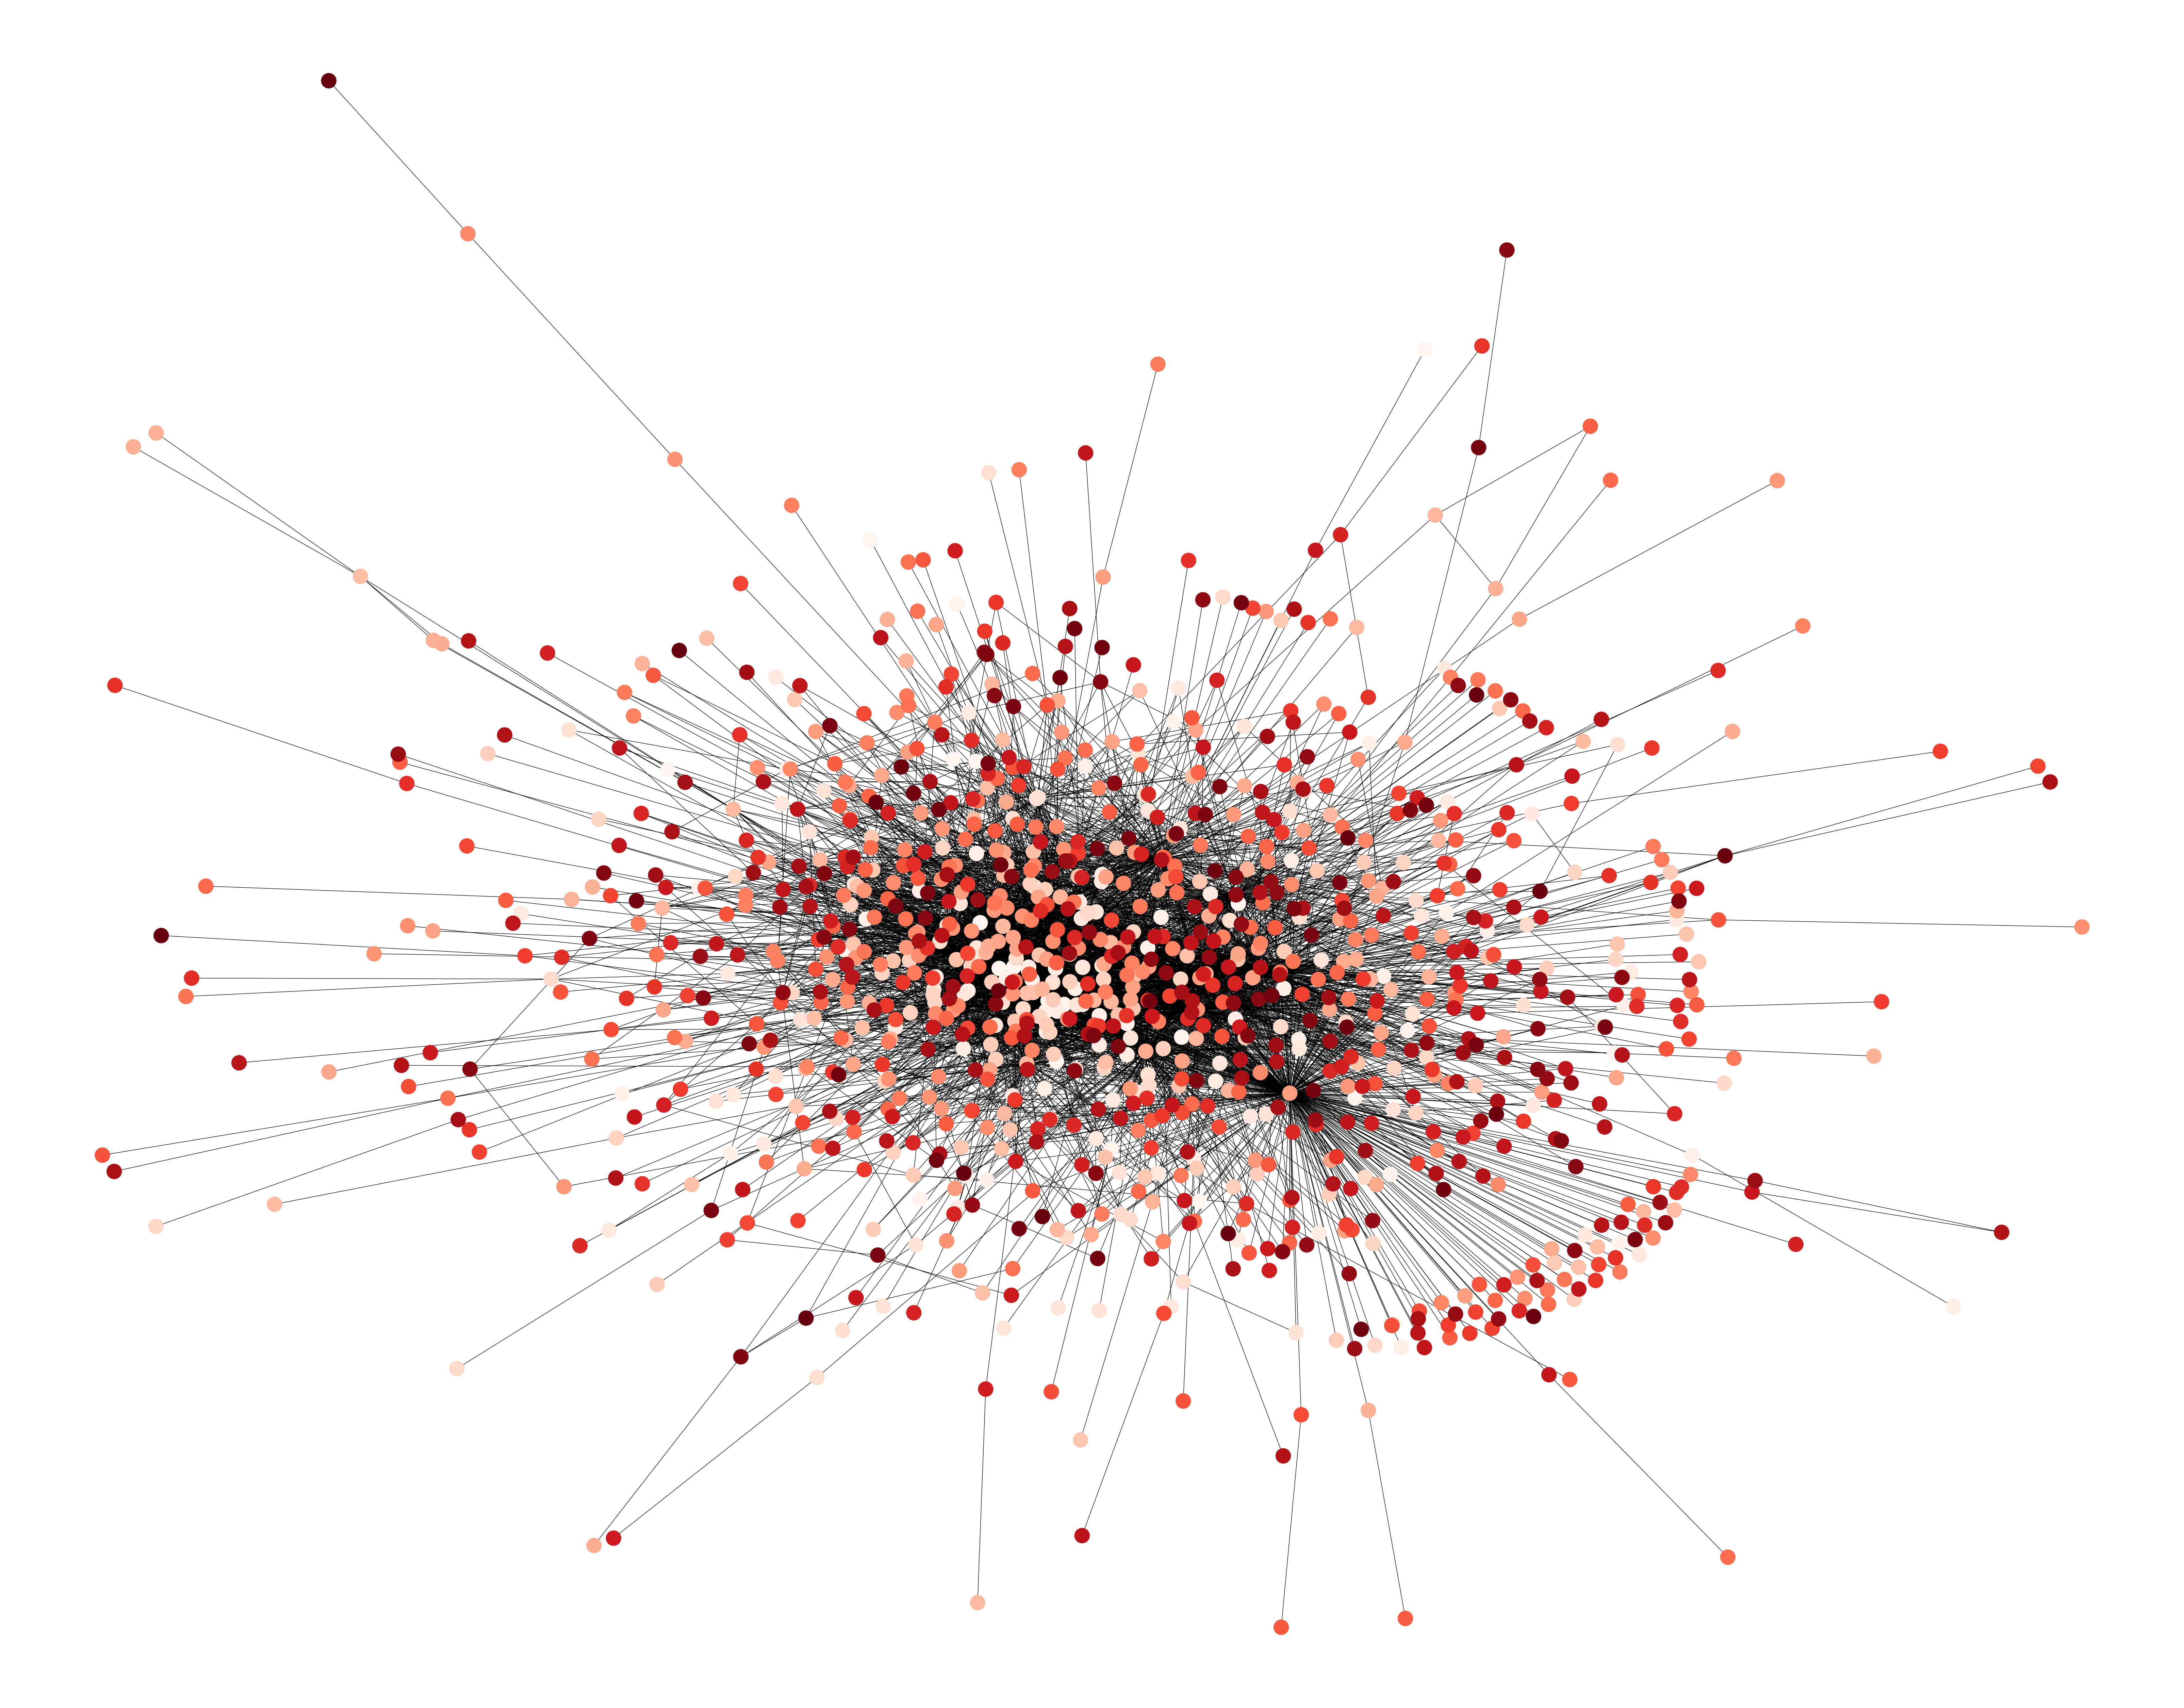

In [20]:
def show_graph_core(users_adjacency_matrix):
    
    # TODO 3:
    graph =nx.from_numpy_matrix(users_adjacency_matrix)
    centrality = nx.eigenvector_centrality(graph)
    remove = [node for node in centrality if centrality[node]< 0.00000001]
    graph.remove_nodes_from(remove)
    print("Total number of significant nodes:", nx.number_of_nodes(graph))
    
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(64, 50), dpi=100)
    nx.draw(graph,
            node_size=1000,
            node_color=range(nx.number_of_nodes(graph)),
            cmap=plt.cm.Reds,
            pos=nx.spring_layout(graph)
           )
    plt.show()

    
show_graph_core(users_adjacency_matrix)

**4.** Do you think the social context could further improve our hate speech detection model? Find at least 2 pros and 2 cons.

**TODO 4: Write your observations here**

Pros:
- Like minded people tend to connect with like minded people, therefore, adding information about the authors network seems to make sense
- Language is always open to interpretations and the sender might mean something else than the receiver interprets, therefore, context gives additional information to interpret more precisely

Cons:
- It depends on the goal of the hate speech detector, but if a decision should be made from an objective point of view, then context reduces the objectivity and therefore, the qualitative results of a detector
E.g. If we add sex of author as context and there are more tweets with male authors related to sexism than female. Then the network might receive a bias that might be statistically true but removes objectivity
- If we add social context that has correlation but is not causation then it might improve on our limited dataset but performance decreases in real world.
However, this is more an issue of the data sampling

### b) Employment of our Base Model to predict the hatefulness of an author's followers

Now that we have a trained model, we can use it to predict the hatefulness for any tweet. Therefore, we can use it to predict an average hate score for each follower of an author. This means that we predict the label for each tweet of an author's follower and then compute an average across all of these predictions. 

**1.** Predict all encoded tweets with the Base Model

In [21]:
# TODO 1:
all_data = np.asarray(np.vstack(waseem_hovy['embedding'])).astype('float32')
all_predictions = base_model.predict(all_data)
all_predictions_transformed = np.zeros_like(all_predictions)

all_predictions_transformed[np.arange(len(all_predictions)), all_predictions.argmax(1)] = 1
all_predictions_transformed=all_predictions_transformed.astype(int)

waseem_hovy['predictions'] = all_predictions_transformed.tolist()
print(waseem_hovy['predictions'])

0        [0, 1, 0]
1        [1, 0, 0]
2        [0, 1, 0]
3        [0, 1, 0]
4        [0, 1, 0]
           ...    
16844    [0, 1, 0]
16845    [0, 1, 0]
16846    [0, 1, 0]
16847    [0, 1, 0]
16848    [0, 1, 0]
Name: predictions, Length: 16849, dtype: object


In the following code cell we load the authorship numpy array. It contains the author ID of each tweet.

In [22]:
# Loads authorship index
authors_idx = np.load("pickle_files/users_data/authorship.npy")
authors_idx = np.reshape(authors_idx, newshape=(-1, 1))


**2.** Now for every tweet of our dataset we need to compute its authors hate score. Therefore:
 * First define a function `get_all_followers` that return all followers for a given user.
 * Then create a list `his_followers` that contains all followers for each user.
 * Now assign the hate predictions for each of all the followers tweets.
 * Finally in `user_avg_score` compute the hate score for each user by averaging out all his followers' tweets' hate scores. If there are no followers' tweets, assign our pre-computed average values `default_hate_score`.

In [23]:
default_hate_score = np.array([0.19446494, 0.75084399, 0.0546911])
graph =nx.from_numpy_matrix(users_adjacency_matrix)

# TODO 2:
def get_all_followers(user,graph =nx.from_numpy_matrix(users_adjacency_matrix)):
    
    return [n for n in graph.neighbors(user)]

print(get_all_followers(1))
#a dict (think this is better suited here than list...) containing all followers for each user
his_followers =dict()
for node in graph.nodes:
    his_followers.update({node:get_all_followers(node)})

#Assigning Hate Predictions to each user by creating a new dict

print(his_followers[1])
#waseem_hovy['followers'] = waseem_hovy.apply(lambda row:get_all_followers(row.name),axis=1)
#print(waseem_hovy['followers'])
#his_followers =[]
#for node in graph.nodes:
    
waseem_hovy["author"]=authors_idx
def custom_sum(series):
    result=np.array([0,0,0])
    for elem in series:
        result+=np.array(elem)        
    return result.tolist()

hate_scores_per_author = dict()
for author,followers in his_followers.items():
    print(author)
    #followers = his_followers[author]
    #print(followers)
    hate_score =np.array([.0,.0,.0])
    count_tweets=0
    if followers:
        for follower in followers:
            follower_tweets = waseem_hovy.loc[waseem_hovy['author'] == follower]
            #if there are no tweets fall back to default
            if len(follower_tweets)==0:
                hate_score = default_hate_score
                count_tweets=1
                break
            count_tweets += len(follower_tweets)
            #if one ones to use predicted values one has to exchange the two label_mapping instances by prediction
            #I tried this out as well, as described below. However, working with predicted values is not necessary
            # and does in my opionion only corrupt the training data, so I continue here with ground truth data
            sum = follower_tweets.groupby(['author'])['label_mapping'].agg(custom_sum).reset_index()['label_mapping']
            hate_score +=np.array(sum[0])
        hate_score /= count_tweets
    else:
        #if there are no followers = no tweets -->fall back to default
        hate_score = default_hate_score
    hate_scores_per_author.update({author:hate_score.tolist()})

    
print(hate_scores_per_author[0])
print(hate_scores_per_author[1])
print(hate_scores_per_author[2])
        
      
        
        


[502, 690, 712, 727, 729, 858, 914, 1022, 1035, 1653, 1680, 1880, 1914]
[502, 690, 712, 727, 729, 858, 914, 1022, 1035, 1653, 1680, 1880, 1914]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
24

1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
[0.19446494, 0.75084399, 0.0546911]
[0.03571428571428571, 0.9642857142857143, 0.0]
[0.19446494, 0.75084399, 0.0546911]


In [24]:
###
# I Removed the dafault code as I do want to store my whole data in one pandas Dataframe
###

hate_score_data = pd.DataFrame([hate_scores_per_author]).T.reset_index()
hate_score_data=hate_score_data.rename(columns={'index':'author',0:'authors_hate_score'})
print(hate_score_data)

# Put authors' hate scores in the order of the tweets
#tweets_author_hate_score = list((map(lambda x: user_avg_score[int(x)], authors_idx))) 

#tweets_author_hate_score = np.array(tweets_author_hate_score)

      author                                 authors_hate_score
0          0                [0.19446494, 0.75084399, 0.0546911]
1          1     [0.03571428571428571, 0.9642857142857143, 0.0]
2          2                [0.19446494, 0.75084399, 0.0546911]
3          3                [0.19446494, 0.75084399, 0.0546911]
4          4  [0.30303030303030304, 0.6666666666666666, 0.03...
...      ...                                                ...
2026    2026                                    [0.0, 1.0, 0.0]
2027    2027                                    [0.0, 1.0, 0.0]
2028    2028                                    [0.0, 1.0, 0.0]
2029    2029                                    [0.0, 1.0, 0.0]
2030    2030                                    [0.0, 1.0, 0.0]

[2031 rows x 2 columns]


## Task 5.4: Social Model 

Now that we have our social context prepared, we can build and train our Social Model using that information.

### a) Social Model creation

With our social context we have 2 separate networks: 
* Our text network that processes the tweet (the same as the base model from before)
* Our hate score network that basically decides how important the average hate score for the classification is

Our 2 separate networks are concatenated and one last hidden layer with 100 nodes is added. 

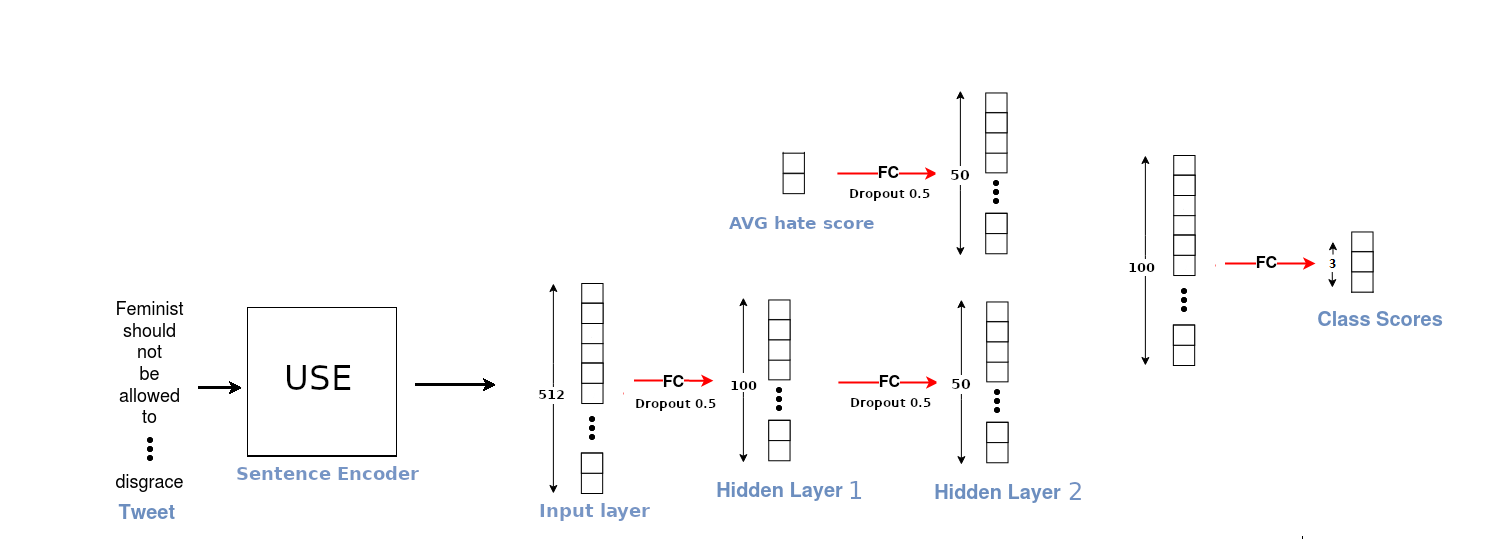

Now define our new neural network `social_model` according to the graphic above. You can lookup most of the syntax in exercise ***5.2 a)***.

In [54]:
# TODO:
ENCODING_DIM = 512

text = layers.Input(shape=(ENCODING_DIM, ))

x1 = layers.Dense(100, activation='relu')(text)
x1 = layers.Dropout(0.5)(x1)

# TODO: The 50 nodes layer with 0.5 dropout is missing. Add this layer between the 100 layer and the output layer
x2 = layers.Dense(50, activation='relu')(x1)
x2 = layers.Dropout(0.5)(x2)

hate_score_input = layers.Input(shape=(3,))
x3 = layers.Dense(50, activation='relu')(hate_score_input)
x3 = layers.Dropout(0.5)(x3)

concat = layers.Concatenate(axis=1)([x2, x3])

x4 = layers.Dense(100, activation='relu')(concat)


output = layers.Dense(3, activation="softmax") (x4)

social_model = Model(inputs=[text,hate_score_input], outputs=output)


In [55]:
# Compiles the model defining loss, accuracy metric and optimizer

optimizer = tf.keras.optimizers.Adam(lr=0.0005)

social_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['categorical_accuracy'])
social_model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
dense_17 (Dense)                (None, 100)          51300       input_7[0][0]                    
__________________________________________________________________________________________________
dropout_11 (Dropout)            (None, 100)          0           dense_17[0][0]                   
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 3)]          0                                            
______________________________________________________________________________________

### b) Train-Test split for Social Model
Now split the data in Train/Val/Test 60/20/20 as seen in the Base Model. This time you have to create an additional set for the Hate Score.

In [56]:
# Notice to examiners: This is quite bad practice, you should us allow to first build one dataset including hate_score 
# and then let us evaluate the two models on the same dataset/training /test split

# TODO: Split tweets and labels in Train/Test/Validation 60/20/20
final_dataset = pd.merge(waseem_hovy,hate_score_data,how="left",on="author")
print(final_dataset.info())
print(final_dataset.head())
train, test_val=train_test_split(final_dataset, test_size=0.4, random_state=42)

val,test = train_test_split(test_val,test_size=0.5,random_state=42)

X_train = np.vstack(train["embedding"])
a_train =np.vstack(train["authors_hate_score"])
print(X_train)#train['embedding'].apply(tf.squeeze).apply(np.array).values
y_train = np.vstack(train['label_mapping'])#.values
X_val = np.vstack(val["embedding"])
a_val =np.vstack(val["authors_hate_score"])
y_val = np.vstack(val['label_mapping'].apply(np.squeeze))

X_test = np.vstack(test['embedding'])
a_test =np.vstack(test["authors_hate_score"])
y_test = np.vstack(test['label_mapping'].apply(np.squeeze))



print("Training data shape: {}, Labels shape: {}, Hate Score shape: {}".format(X_train.shape, y_train.shape, a_train.shape))
print("Test data shape: {}, Labels shape: {}, Hate Score shape: {}".format(X_test.shape, y_test.shape, a_test.shape))
print("Validation data shape: {}, Labels shape: {}, Hate Score shape: {}".format(X_val.shape, y_val.shape, a_val.shape))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16849 entries, 0 to 16848
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                16849 non-null  object
 1   label               16849 non-null  object
 2   label_mapping       16849 non-null  object
 3   embedding           16849 non-null  object
 4   predictions         16849 non-null  object
 5   author              16849 non-null  int64 
 6   authors_hate_score  16849 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.0+ MB
None
                                                text   label label_mapping  \
0  "@Brittany_Blade: #FemFreeFriday because fems ...  sexism     [1, 0, 0]   
1  "@CarlyandTresne: I still can't believe that K...    none     [0, 1, 0]   
2  "@CarlyandTresne: You don't suck Sheri and Emi...    none     [0, 1, 0]   
3  "@ColinCowell: Don't go bacon my heart ..........    none     [0, 1, 0]   
4  "@ErikssonMa

### c) Train and Evaluate the Enhanced Model
Once again, train and evaluate the model with a F1 Score. Use 20 `epochs` and `batch_size` of 32.

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20

Epoch 00014: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
{'loss': [0.5950804948806763, 0.39494791626930237, 0.36549678444862366, 0.34689176082611084, 0.32757604122161865, 0.3138270378112793, 0.3087347447872162, 0.2972732484340668, 0.2836337685585022, 0.2728542387485504, 0.2700405716896057, 0.2495768517255783, 0.2435850352048874, 0.232573464512825, 0.21825505793094635, 0.21517683565616608, 0.21069850027561188, 0.20593704283237457, 0.20762823522090912, 0.20216631889343262], 'categorical_accuracy': [0.7533880472183228, 0.8354931473731995, 0.851518452167511, 0.8582451343536377, 0.863982617855072, 0.872885525226593, 0.8725887537002563, 0.8801068067550659, 0.8843604922294617, 0.8882184028625488, 0.894747257232666, 0.8994954824447632, 0.9037

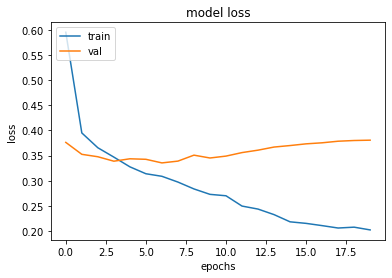

In [57]:
from matplotlib import pyplot as plt

# TODO: Train the model
checkpoint = callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_learning_rate = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=0, mode='min')
# TODO: Train the model

BATCH_SIZE = 32

# TODO: Train the model
# Hint: When using the fit function, also pass the validation_data as a parameter
model_training=social_model.fit(
    x=[X_train,a_train],
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    verbose="auto",
    callbacks=[checkpoint,reduce_learning_rate],
    validation_split=0.0,
    validation_data=([X_val,a_val],y_val),
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=20,
    use_multiprocessing=True,
)

# Print the model's history and plot the loss for each epoch
print(model_training.history)
plt.plot(model_training.history['loss'])
plt.plot(model_training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [58]:

# the f1_score_overall is a quite ill explained/documented helper function ( in particular as you dont tell us what variables should have what format),
# understanding and adjusting my code takes longer than doing it myself...

#predict
predictions=social_model.predict([X_test,a_test])

#transform prediction to 0 & 1
transformed_predictions = np.zeros_like(predictions)
transformed_predictions[np.arange(len(predictions)), predictions.argmax(1)] = 1
transformed_predictions=transformed_predictions.astype(int)

#calculate f1
overall = 0
for i in range(0,3):
    current = f1_score(y_test.T[i], transformed_predictions.T[i])
    print ( "F1-score for class ",i," is: ", current)
    overall+=current

print("F1-score overall is: ",overall/3)

share_of_labels =np.array(custom_sum(waseem_hovy['label_mapping']))/len(waseem_hovy['label_mapping'])
print("Share of Labels:")
print(share_of_labels)


F1-score for class  0  is:  0.8086754453911696
F1-score for class  1  is:  0.9052858683926646
F1-score for class  2  is:  0.7567567567567567
F1-score overall is:  0.823572690180197
Share of Labels:
[0.20048668 0.68259244 0.11692089]


#### F1-Scores for social_model obtained when training with hate_scores based on predicted labels

- F1-score for class  0  is:  0.7990353697749196
- F1-score for class  1  is:  0.9036530655842768
- F1-score for class  2  is:  0.7484662576687116
- F1-score overall is:  0.8170515643426359

#### F1-Scores of Base model:
- F1-score for class  0  is:  0.6793703396851698
- F1-score for class  1  is:  0.8778738662729382
- F1-score for class  2  is:  0.7525252525252525
- F1-score overall is:  0.7699231528277868

## Task 5.5: Discussion and comparison

* Compare the performances of our two models in your own words

* Why do you think it improved? 

* Can you think of any other social context to further improve our model?

**TODO: Write your thoughts here**

Comparing the F1- scores one can see that the social model supercedes the base model by ~0.05.
Interestingly, the F1-score of sexism improves relatively strong with ~0.13 while none improves by 0.3 and racism actually worsens by 0.2

First thought was to compare the share of labels if it might explain why the f1 distribution across the label changes that differently.
However, there is no correlation.
An Idea (but mere speculation) is that people posting sexistic things are more prone to follow/connect with like minded people resulting in an bigger explanatory power of the hate score for this label

I think it would be interesting to adding any descriptive information of the author that can be found online. E.g. sex, political direction, educational level, job status etc.



## References

[1] Festinger, L., Pepitone, A. and Newcomb, T. (1952) *Some Consequences of De-Individuation in a Group.* Journal of Abnormal and Social Psychology, 47, 382-389.
<br>[2] Waseem, Z., & Hovy, D. (2016). *Hateful symbols or hateful people? Predictive features for hate speech detection on Twitter.* In Proceedings of the naacl student research workshop (pp. 88-93).
<br>[3] https://keras.io/about/
<br>[4] https://tfhub.dev/google/universal-sentence-encoder/4
<br>[5] https://medium.com/@shaistha24/basic-concepts-you-should-know-before-starting-with-the-neural-networks-nn-3-6db79028e56d
<br>[6] Jahn, L. (2020). *Leveraging Social Network Data for Hate Speech Detection.* Master
Thesis, Technical University of Munich, Department of Informatics.